# Setup
## Imports

In [21]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import scipy
from generative_social_choice.utils.helper_functions import get_base_dir_path


## Constants

In [23]:
likert_scores: dict[int, str] = {
    0: "Very poorly",
    1: "Poorly",
    2: "Moderately",
    3: "Well",
    4: "Very well",
    5: "Excellently",
    6: "Exceptionally",
}
likert_scores_reverse: dict[str, int] = {v: k for k, v in likert_scores.items()}


## Load data

In [24]:
data_dir_path = get_base_dir_path() / "data" / "demo_data"
baseline_prefix = "baseline_"
baseline_assignments_file_path = data_dir_path / f"{baseline_prefix}assignments.json"

with open(baseline_assignments_file_path, "r") as f:
    baseline_assignment_data = (json.load(f))


baseline_assignment_data.keys()


dict_keys(['slate', 'slate_statements', 'agent_ids', 'assignments', 'utilities', 'info'])

In [34]:
# Create DataFrame with assignments and utilities
baseline_assignments = pd.DataFrame({
    'candidate_id': baseline_assignment_data['assignments'],
    'utility': baseline_assignment_data['utilities']
}, index=baseline_assignment_data['agent_ids'])
baseline_assignments.head()


,candidate_id,utility
generation1,s1,3.875477
generation2,s2,3.891122
generation3,s4,3.922493
generation4,s1,3.940659
generation5,s5,3.914099


In [35]:
algo_assignment_files = {
    "Exact Total": data_dir_path / "assignments" / "exact.json",
    "Greedy Total": data_dir_path / "assignments" / "greedy.json",
    "LP Total": data_dir_path / "assignments" / "lp.json",
    "Phragmen": data_dir_path / "assignments" / "phragmen.json",
}

utilities = pd.DataFrame(columns=["Baseline"] + list(algo_assignment_files.keys()), index=baseline_assignments.index)
utilities["Baseline"] = baseline_assignments["utility"]

for algo_name, file_path in algo_assignment_files.items():
    with open(file_path, "r") as f:
        algo_assignment_data = (json.load(f))
        algo_utilities = pd.Series(algo_assignment_data['utilities'], index=algo_assignment_data['agent_ids'])
        utilities[algo_name] = algo_utilities


utilities.head(40)


# all_algorithm_utilities

,Baseline,Exact Total,Greedy Total,LP Total,Phragmen
generation1,3.875477,3.896713,3.896713,3.896713,3.896713
generation2,3.891122,3.957636,3.957636,3.957636,3.957636
generation3,3.922493,3.946402,3.946402,3.946402,3.946402
generation4,3.940659,3.985354,3.985354,3.985354,3.985354
generation5,3.914099,3.951754,3.951754,3.976176,3.951754
generation6,3.934762,3.929366,3.929366,3.929366,3.929366
generation7,3.954626,3.956355,3.956355,3.956355,3.956355
generation8,3.925924,3.990339,3.990339,3.990339,3.990339
generation9,3.680190,3.690291,3.690291,3.529403,3.529403
generation10,3.908748,3.977783,3.977783,3.977783,3.977783


# Plots

In [36]:
def calculate_proportion_confidence_intervals(counts: np.ndarray, total: int) -> np.ndarray:
    """
    Calculate confidence intervals for proportions, including exact calculation for small counts where the normal approximation is not valid.
    """
    proportions = counts / total
    nqp = counts * proportions
    standard_errors = np.sqrt(proportions * (1 - proportions) / total)
    
    # Initialize bounds with normal approximation
    lower_bounds = np.maximum(0, proportions - standard_errors)
    upper_bounds = np.minimum(1, proportions + standard_errors)
    
    # Identify indices where exact calculation is needed
    exact_indices = nqp < 5
    
    # Exact binomial calculation for nqp < 5
    if np.any(exact_indices):
        exact_lower = scipy.stats.binom.ppf(0.025, total, proportions[exact_indices]) / total
        exact_upper = scipy.stats.binom.ppf(0.975, total, proportions[exact_indices]) / total
        lower_bounds[exact_indices] = exact_lower
        upper_bounds[exact_indices] = exact_upper
    
    return np.vstack((lower_bounds, proportions, upper_bounds)).T

## Trial-only plots


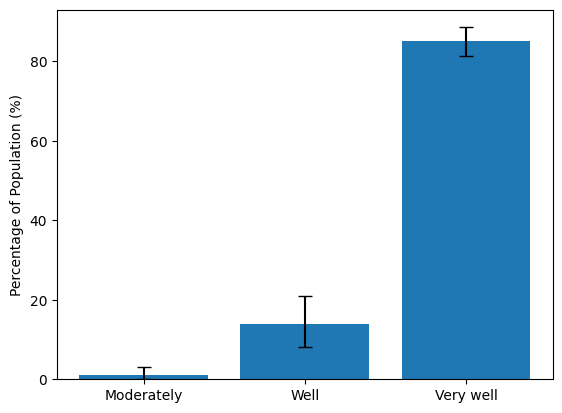

In [40]:
def plot_likert_category_bar_chart(assignments: pd.DataFrame) -> plt.figure:
    """
    Bar chart of the distribution of likert scores with error bars.

    Utilities are rounded to the nearest integer and mapped to the likert scale.
    Bars are sequenced from lowest to highest likert score.
    The y axis is the percentage of the sample that received each score.
    Error bars represent the standard error of the proportion.
    """
    # Round utilities and map to likert scores
    assignments["utility"] = assignments["utility"].round().astype(int)
    assignments["likert_score"] = assignments["utility"].map(likert_scores)
    
    # Calculate counts
    total = len(assignments)
    counts = assignments["likert_score"].value_counts().sort_index()

    confidence_intervals = calculate_proportion_confidence_intervals(counts.values, total)
    
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        "likert_score": counts.index,
        "proportion": confidence_intervals[:, 1],
        "lower_bound": confidence_intervals[:, 0],
        "upper_bound": confidence_intervals[:, 2]
    }).sort_values("likert_score")

    # Sort the plot data by likert score using the reverse mapping
    plot_data = plot_data.sort_values(
        "likert_score", 
        key=lambda x: x.map(likert_scores_reverse)
    )
    
    # Convert proportions to percentages for plotting
    plot_data["percentage"] = plot_data["proportion"] * 100
    plot_data["lower_bound_percentage"] = plot_data["lower_bound"] * 100
    plot_data["upper_bound_percentage"] = plot_data["upper_bound"] * 100
    
    yerr = np.array([
        plot_data["percentage"] - plot_data["lower_bound_percentage"],
        plot_data["upper_bound_percentage"] - plot_data["percentage"]
    ])
    
    # Create figure and axis objects explicitly
    fig, ax = plt.subplots()
    
    # Create bar plot
    bars = ax.bar(
        x=range(len(plot_data)),
        height=plot_data["percentage"],
        yerr=yerr,
        capsize=5
    )
    
    # Customize x-axis
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(
        plot_data["likert_score"],
        # rotation=45 if len(plot_data) > 4 else 0
    )
    
    # Customize y-axis
    ax.set_ylabel("Percentage of Population (%)")
    
    return fig

fig = plot_likert_category_bar_chart(baseline_assignments)

## Trial vs Baseline Plots

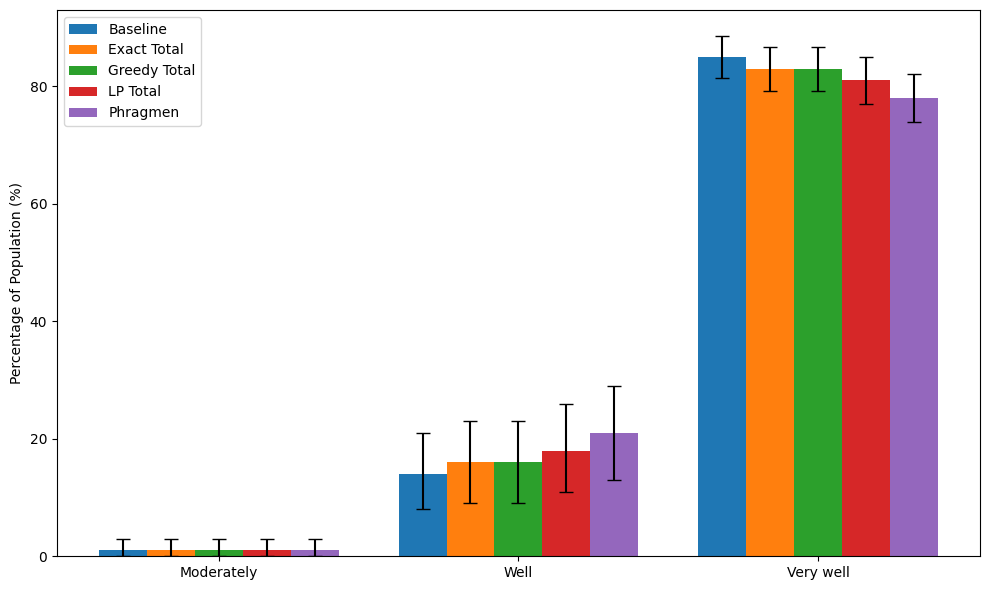

In [39]:
def plot_likert_category_clustered_bar_chart(
    utilities: pd.DataFrame,
    labels: dict[str, str] | None = None,
) -> plt.Figure:
    """
    Clustered bar chart comparing the distribution of likert scores across multiple
    datasets with error bars.

    Args:
        utilities: DataFrame where each column contains utilities for a different
            dataset/condition
        labels: Optional dictionary mapping column names to display labels. If not
            provided, uses the column names directly.

    Returns:
        matplotlib Figure object containing the plot
    """
    # Process each dataset/column
    plot_data_dict = {}
    for column in utilities.columns:
        # Round utilities and map to likert scores
        df = pd.DataFrame({"utility": utilities[column]}).copy()
        df["utility"] = df["utility"].round().astype(int)
        df["likert_score"] = df["utility"].map(likert_scores)
        
        # Calculate counts and proportions
        total = len(df)
        counts = df["likert_score"].value_counts().sort_index()
        
        # Calculate confidence intervals
        confidence_intervals = calculate_proportion_confidence_intervals(
            counts.values, 
            total
        )
        
        # Create DataFrame for this dataset
        plot_data = pd.DataFrame({
            "likert_score": counts.index,
            "proportion": confidence_intervals[:, 1],
            "lower_bound": confidence_intervals[:, 0],
            "upper_bound": confidence_intervals[:, 2]
        })
        
        # Sort by likert score
        plot_data = plot_data.sort_values(
            "likert_score", 
            key=lambda x: x.map(likert_scores_reverse)
        )
        
        # Convert to percentages
        plot_data["percentage"] = plot_data["proportion"] * 100
        plot_data["lower_bound_percentage"] = plot_data["lower_bound"] * 100
        plot_data["upper_bound_percentage"] = plot_data["upper_bound"] * 100
        
        plot_data_dict[column] = plot_data

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate bar positions
    n_datasets = len(utilities.columns)
    bar_width = 0.8 / n_datasets  # Adjust total width of group
    
    # Get unique sorted likert scores across all datasets
    all_scores = sorted(
        set().union(*[df["likert_score"] for df in plot_data_dict.values()]),
        key=lambda x: likert_scores_reverse[x]
    )
    x = np.arange(len(all_scores))
    
    # Plot bars for each dataset
    for i, (column, plot_data) in enumerate(plot_data_dict.items()):
        # Calculate bar positions
        offset = (i - (n_datasets - 1) / 2) * bar_width
        x_pos = x + offset
        
        # Ensure data exists for all scores
        heights = []
        yerr = [[], []]
        for score in all_scores:
            score_data = plot_data[plot_data["likert_score"] == score]
            if len(score_data) > 0:
                heights.append(score_data["percentage"].iloc[0])
                yerr[0].append(
                    score_data["percentage"].iloc[0] - 
                    score_data["lower_bound_percentage"].iloc[0]
                )
                yerr[1].append(
                    score_data["upper_bound_percentage"].iloc[0] - 
                    score_data["percentage"].iloc[0]
                )
            else:
                heights.append(0)
                yerr[0].append(0)
                yerr[1].append(0)
        
        # Plot bars
        label = labels[column] if labels else column
        ax.bar(
            x_pos,
            heights,
            bar_width,
            yerr=yerr,
            capsize=5,
            label=label
        )
    
    # Customize plot
    ax.set_ylabel("Percentage of Population (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(
        all_scores,
        rotation=45 if len(all_scores) > 4 else 0
    )
    
    # Add legend
    ax.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

fig = plot_likert_category_clustered_bar_chart(utilities)

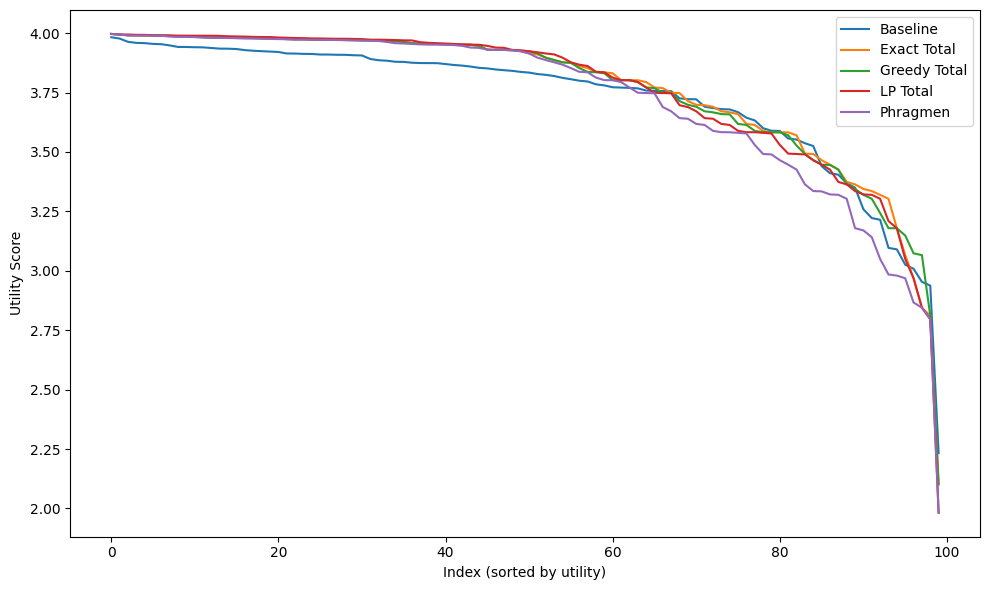

In [41]:
def plot_sorted_utility_distributions(utilities: pd.DataFrame) -> plt.Figure:
    """
    Plot sorted utility distributions for each column in the DataFrame.
    
    Args:
        utilities: DataFrame where each column contains utilities for different
            methods/conditions
    
    Returns:
        matplotlib Figure object containing the plot
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each column's sorted distribution
    for column in utilities.columns:
        sorted_values = utilities[column].sort_values(ascending=False).values
        indices = np.arange(len(sorted_values))
        ax.plot(indices, sorted_values, label=column)
    
    # Customize plot
    ax.set_xlabel("Index (sorted by utility)")
    ax.set_ylabel("Utility Score")
    ax.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

fig = plot_sorted_utility_distributions(utilities)